In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install imutils

!pip install roboflow

!pip install pytube --upgrade

In [3]:
pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fmilqj9l
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fmilqj9l
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=6503ce39c3b2d09d0fb2c1aaac52a1e9ff0b85e70fb84961a5e460082c25bbc6
  Stored in directory: /tmp/pip-ephem-wheel-cache-_q7tbgu9/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything


In [4]:
!pip install ipython

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)


In [5]:
!pip install super-gradients==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of sphinx-rtd-theme to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import torch
torch.__version__

'2.4.1+cu121'

In [8]:
print(torch.cuda.is_available())

True


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [6]:
from super_gradients.training import models
import pickle

The console stream is logged into /root/sg_logs/console.log


[2024-10-01 09:43:49] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-10-01 09:43:52] INFO - utils.py - NumExpr defaulting to 2 threads.
/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:32: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
[2024-10-01 09:43:55] WARNING - __init__.py - Failed to import pytorch_quantization
[2024-10-01 09:43:55] WARNI

In [7]:
# Load the model architecture
model = models.get('yolo_nas_s', num_classes=2, checkpoint_path='/content/drive/MyDrive/AI/models/ckpt_best.pth')

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/usr/local/lib/python3.10/dist-packages/super_gradients/training/utils/checkpoint_utils.py:155: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(ckpt_pa

YoloNAS_S(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr

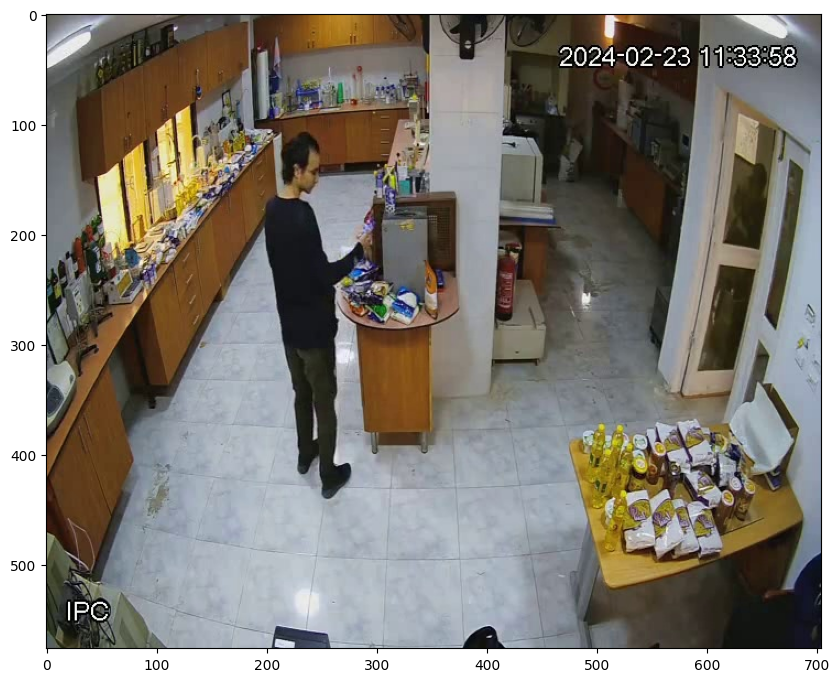

In [11]:
image = cv2.imread('/content/Untitled Folder/shop_lifter_126.mp4_frame_3_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

/usr/local/lib/python3.10/dist-packages/super_gradients/training/pipelines/pipelines.py:184: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with eval_mode(self.model), torch.no_grad(), torch.cuda.amp.autocast():
[2024-10-01 09:48:17] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


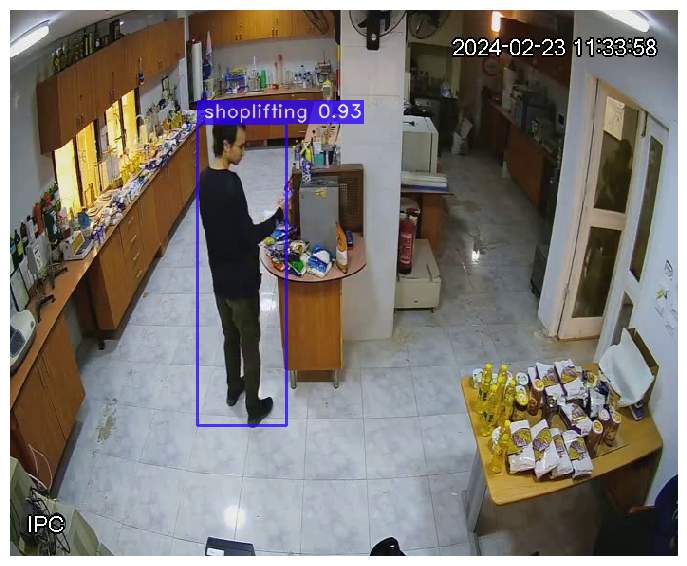

In [12]:
model.predict(image,conf = 0.8).show()

In [13]:
sam_checkpoint = "/content/drive/MyDrive/AI/models/models--kunkaran--sam_vit_h_4b8939.pth/snapshots/f114e74a1cba76ae0fb6998d57e0661eaa87433e/sam_vt_h.pth"
model_type = "vit_h"

device = "cuda"

In [14]:
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

/usr/local/lib/python3.10/dist-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

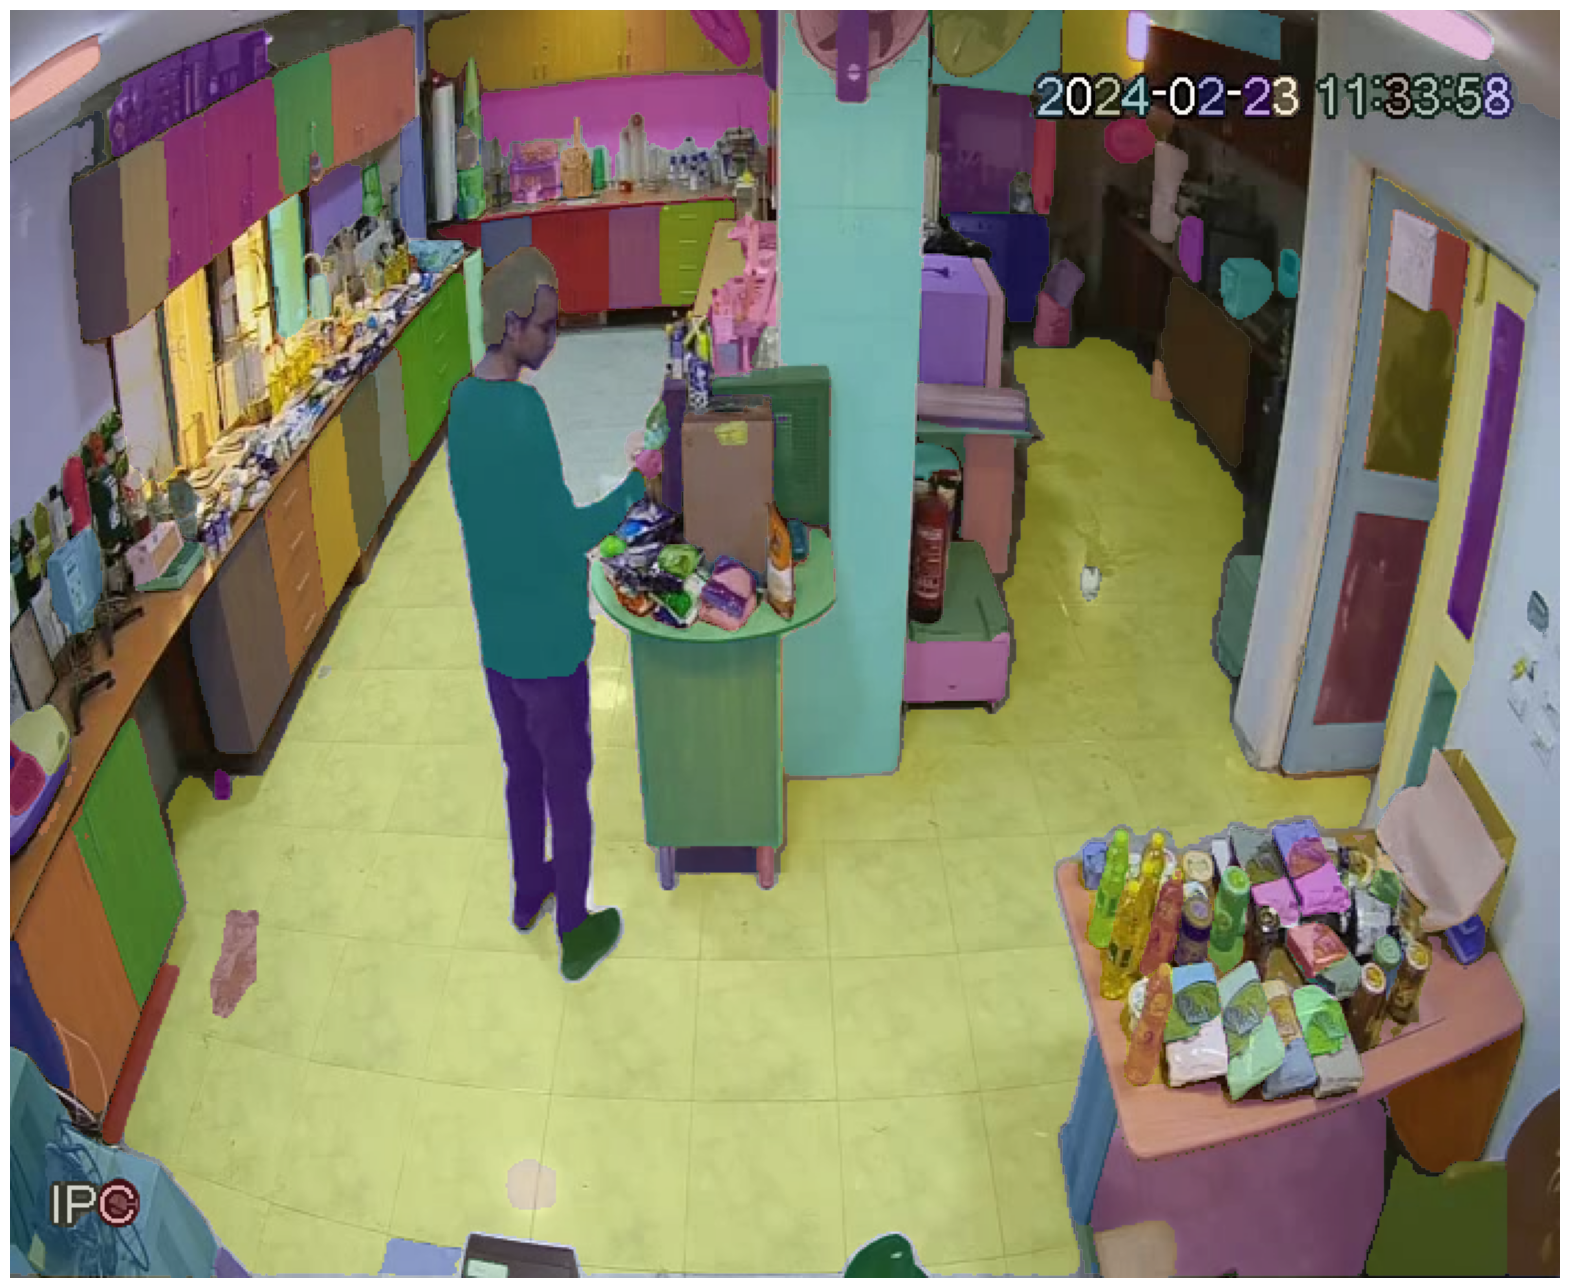

In [15]:
mask_generator = SamAutomaticMaskGenerator(sam)
mask = mask_generator.generate(image)
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(mask)
plt.axis('off')
plt.show()

[2024-10-01 09:51:19] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


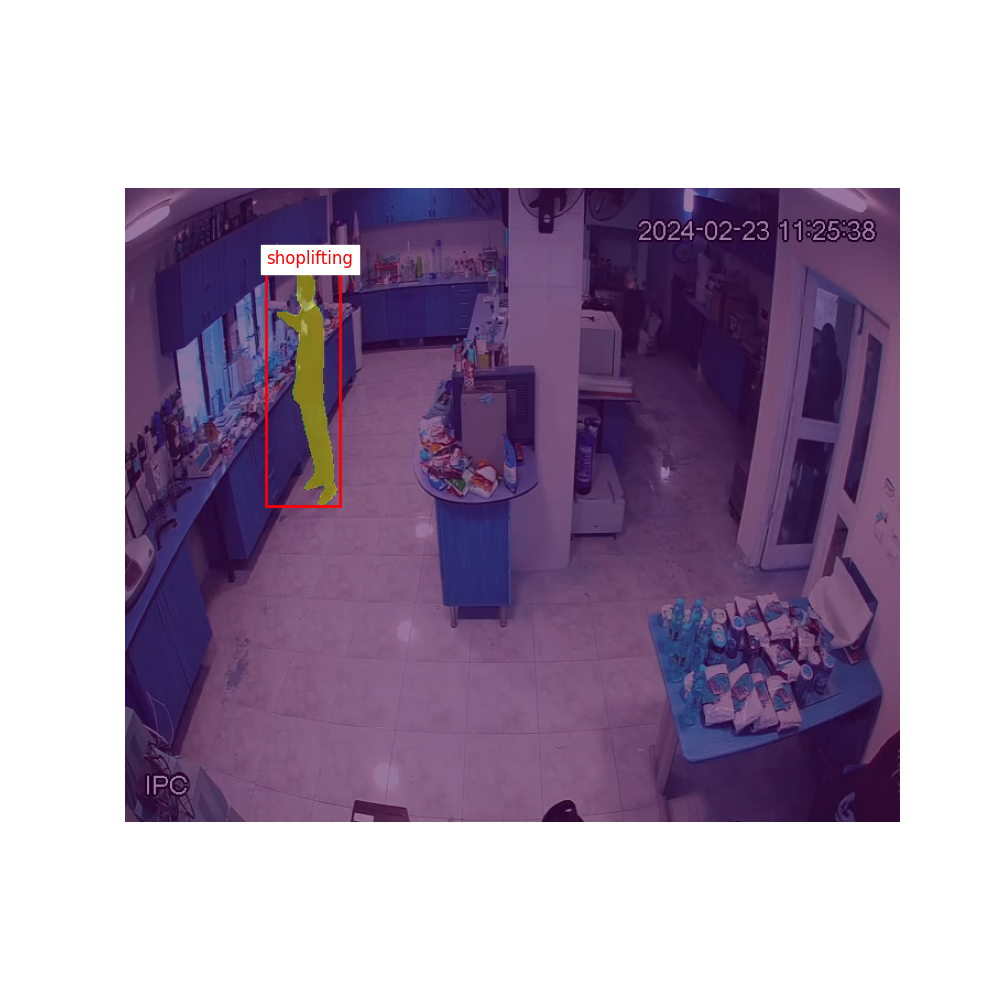

In [16]:
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor
from IPython.display import Image
import io
import numpy as np

def segment_image(image_path, sam, model):
    """Segments an image using the Segment Anything Model (SAM)
       and a detection model.

    Args:
      image_path: Path to the image file.
      sam: The SAM model object.
      model: The object detection model object.

    Returns:
      An IPython.display.Image object with the segmented image.
    """

    # Read and convert the image to RGB
    image2 = cv2.imread(image_path)
    image = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Initialize the SAM predictor
    predictor = SamPredictor(sam)
    predictor.set_image(image)

    # Get predictions from the detection model
    detection_pred = model.predict(image, conf=0.8)._images_prediction_lst
    bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
    confidence = detection_pred[0].prediction.confidence.tolist()
    labels = detection_pred[0].prediction.labels.tolist()

    # Loop through all predictions (multiple objects detected)
    for i, label in enumerate(labels):
        input_box = np.array(bboxes_xyxy[i])
        mask = None

        # Predict the mask for the corresponding bounding box and class label
        mask, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
        )

        plt.figure(figsize=(10, 10))
        plt.imshow(image2)
        plt.imshow(mask[0], alpha=0.5)

        # Add the bounding box and label text
        plt.gca().add_patch(plt.Rectangle((input_box[0], input_box[1]), input_box[2] - input_box[0], input_box[3] - input_box[1], linewidth=2, edgecolor='red', facecolor='none'))

        # Assign label names based on the label number
        if label == 0:
            plt.text(input_box[0], input_box[1] - 5, "shoplifting", fontsize=12, color='r', backgroundcolor='w')
        elif label == 1:
            plt.text(input_box[0], input_box[1] - 5, "non-shoplifting", fontsize=12, color='b', backgroundcolor='w')

        plt.axis('off')

        # Save the figure to a BytesIO object
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # Close the current figure to avoid displaying it twice
        plt.close()

        # Return the image (for each detected object)
        return Image(data=buf.read())


image_path = "/content/Untitled Folder/shop_lifter_116.mp4_frame_1_0.jpg"
segmented_image = segment_image(image_path, sam, model)
segmented_image


[2024-10-01 09:51:40] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


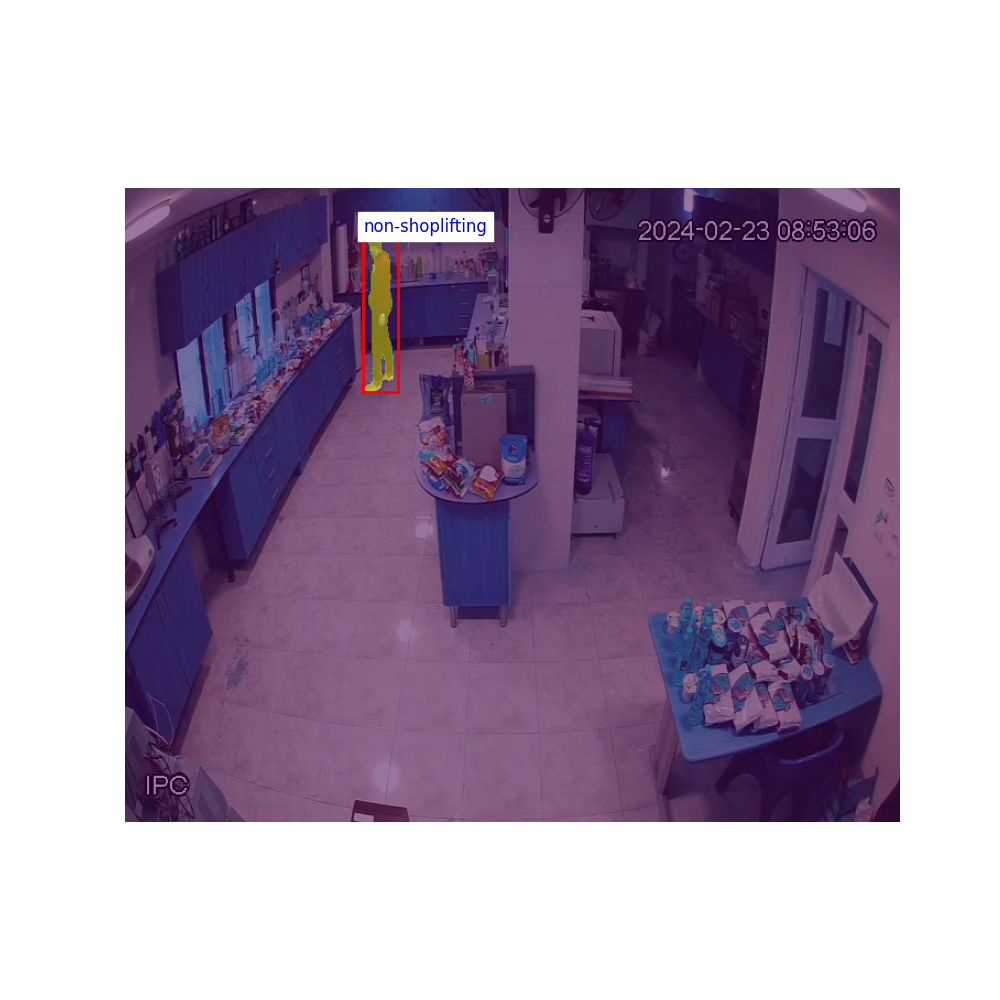

In [17]:
image_path = '/content/Untitled Folder/shop_lifter_n_4_1.mp4_frame_1_0.jpg'
segmented_image = segment_image(image_path, sam, model)
segmented_image

In [20]:
import cv2

# Capture the video
cap = cv2.VideoCapture("/content/drive/MyDrive/Shop DataSet/shop lifters/shop_lifter_10.mp4")

# Get the frames per second (FPS)
fps = cap.get(cv2.CAP_PROP_FPS)

print("FPS:", fps)

cap.release()

FPS: 24.75


In [ ]:
import cv2
import matplotlib.pyplot as plt
from segment_anything import SamPredictor
import numpy as np

def segment_frame(image, sam, model):
    """Segments a single frame using the SAM model and a detection model.

    Args:
      image: A single video frame.
      sam: The SAM model object.
      model: The object detection model object.

    Returns:
      The segmented frame.
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize SAM predictor
    predictor = SamPredictor(sam)
    predictor.set_image(image_rgb)

    # Get predictions from the detection model
    detection_pred = model.predict(image_rgb, conf=0.8)._images_prediction_lst
    bboxes_xyxy = detection_pred[0].prediction.bboxes_xyxy.tolist()
    labels = detection_pred[0].prediction.labels.tolist()

    # Loop through each detected object
    for i, label in enumerate(labels):
        input_box = np.array(bboxes_xyxy[i])
        mask, _, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=input_box,
            multimask_output=False,
        )

        # Overlay the mask onto the frame
        image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
        image[mask[0]] = [0, 255, 0]  # mask in green color

        # Draw the bounding box and label text
        cv2.rectangle(image, (int(input_box[0]), int(input_box[1])), (int(input_box[2]), int(input_box[3])), (255, 0, 0), 2)
        if label == 0:
            cv2.putText(image, 'shoplifting', (int(input_box[0]), int(input_box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
        elif label == 1:
            cv2.putText(image, 'non-shoplifting', (int(input_box[0]), int(input_box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 255), 2)

    return image

def process_video(video_path, sam, model, output_path=None, start_time=3, duration=5):
    """Processes a portion of a video for segmentation using SAM and an object detection model.

    Args:
      video_path: Path to the input video file.
      sam: The SAM model object.
      model: The object detection model object.
      output_path: Optional path to save the output segmented video.
      start_time: The start time (in seconds) from which to begin processing.
      duration: The duration (in seconds) for how long to process the video.
    """
    # Capture the video
    cap = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Calculate the start and end frames
    start_frame = int(fps * start_time)
    end_frame = int(fps * (start_time + duration))

    # Define the codec and create VideoWriter object if output is to be saved
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Set the initial frame to the start_frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    current_frame = start_frame
    while cap.isOpened() and current_frame < end_frame:
        ret, frame = cap.read()
        if not ret:
            break

        # Segment the current frame
        segmented_frame = segment_frame(frame, sam, model)

        # Save the frame to output video if requested
        if output_path:
            out.write(segmented_frame)

        current_frame += 1

    cap.release()
    if output_path:
        out.release()




In [21]:
video_path = "/content/drive/MyDrive/Shop DataSet/shop lifters/shop_lifter_10.mp4"
output_video_path = "output_video2.mp4"

# Process the video for segmentation, starting at 3 seconds and for a duration of 5 seconds
process_video(video_path, sam, model, output_path=output_video_path, start_time=3, duration=7)

[2024-10-01 10:10:51] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-10-01 10:10:53] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-10-01 10:10:55] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-10-01 10:10:57] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-10-01 10:10:59] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-10-01 10:11:01] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`
[2024-10-01 10:11:03] INFO -